In [9]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from collections import namedtuple as nt

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

x_train

array([[ 0.45267141, -1.42381257],
       [ 0.61696406, -0.00418956],
       [-0.60025705, -0.72979921],
       ...,
       [ 0.63107723, -0.4743162 ],
       [-2.09387761, -1.76791586],
       [ 1.07909424, -1.67541279]])

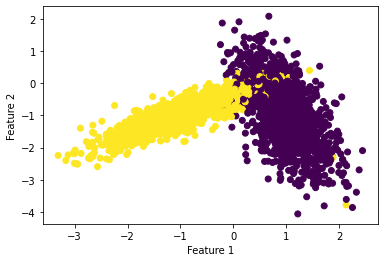

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(x_test[:,0], x_test[:,1],c=y_test,)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [11]:
# ----- CONSTANTS ----

PARAM_CNT = 10 #num of k to be test upon
TRAIN_SCORE = 'TrainScore'
TEST_SCORE = 'TestScore'
HYPER_PARAM = 'HyperParam'

# object that will hold the information derived by the random-search-CV
SearchInfo = nt('SearchInfo', [TRAIN_SCORE, TEST_SCORE, HYPER_PARAM])

# ------ IMPL ------

def randomSearch(x_train, y_train, classifier, params_range, folds):
    '''
    :param x_train: data points
    :param y_train: label points
    :param classifier: classifier model used to train data
    :param params_range: boundary for param val - (n neighbors)
                         | format :- tuple (l, u) // lower & uper bound { inclusive both }
                         | (eg K val lower & uper bound for KNN classification)
    :param folds: number of folds to perform (ie number of buckets to divide data in)
    
    :return : namedtuple obj of train score (Accuracy Score), test score (Accuracy Score), hyper params
    '''
    train_scores = []
    test_scores = []

    l, u = params_range
    assert l < u, "l must be smaller than u"
    
    # As x_train & y_train have equal number of rows
    size = len(y_train)
    
    # 1. get random values for K  -------------------
    d = u-l+1
    k = d if d < PARAM_CNT else PARAM_CNT
    # k vals = hyper - params in case of KNN
    hyper_params = sorted(random.sample(range(l, u+1), k)) # pick k random uniform values from range [l, u]
    # NOTE : sorting hyper_params as per the suggestion to get non-decreasing order

    # 2. BUCKETIZING ie Creating groups  -----------------
    groups = np.array_split(range(size), folds)
    grp_size = len(groups)

    # HYPER_PARAMS
    for k in tqdm(hyper_params):
        #!<i>  indices -> fold number &
        #      val -> metric found in that fold
        train_scores_folds = []  # train scores for different folds ie grps combination
        test_scores_folds = []  # test scores for different folds ie grp combinations
        
        # CURRENT {k} ENTER
        
        # FOLDS
        for i in range(grp_size):  
            # i -> grp_no
            
            # 3. Find the test & train INDICES for current fold  ---------------------
            #.   Pick curr grp as test grp
            #.   & consider rest grp pts as train points
            
            # idxes of curr grp for test pts
            test_idxes = groups[i]
            # chain the indexes into single group
            train_idxes = [idx for gi in range(grp_size) if gi != i for idx in groups[gi]]

            '''
                # NOTE :- when pass arr[[idx1, idx2, idx3]] 
                # in case of n-dimen array ie with multiple axis
                # it will first flaten/ravel the matrix (implicitly) & then 
                # select val present at 3 idxes from a flatten vector
            '''
            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_idxes]
            Y_train = y_train[train_idxes]
            X_test  = x_train[test_idxes]
            Y_test  = y_train[test_idxes]

            # 4. Train Model for current fold {i} & hyper-param {k}  ------------------
            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            test_scores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            train_scores_folds.append(accuracy_score(Y_train, Y_predicted))
        
        # Current {k} EXIT
        # --- at the end of each hyper-param calc, append result to final result list  ---

        #! score will be avg val found for all folds
        train_scores.append(np.mean(np.array(train_scores_folds)))
        test_scores.append(np.mean(np.array(test_scores_folds)))
        
    #return train_scores, test_scores
    return SearchInfo(train_scores, test_scores, hyper_params)

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

Hyper Parameters :  [3, 4, 6, 12, 13, 15, 17, 21, 22, 23]


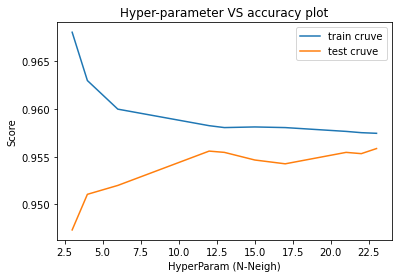

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

# KNN Classifier Estimator
knn_classif = KNeighborsClassifier()

#params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}
boundary = (3, 23)  # range for `n_neighbors`
folds = 3

# get information via random search CV
info = randomSearch(x_train, y_train, knn_classif, boundary, folds)

# Score = Accuracy
trainscores = info.TrainScore
testscores = info.TestScore
hyperparams = info.HyperParam

print('Hyper Parameters : ', hyperparams)

# trainerrors = 1 - np.array(trainscores, dtype=int)
# testerrors = 1 - np.array(testscores, dtype=int)

plt.plot(hyperparams, trainscores, label='train cruve')  
plt.plot(hyperparams, testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.xlabel('HyperParam (N-Neigh)')
plt.ylabel('Score')
plt.show()

In [13]:
n_neigh_hp = 22

In [14]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    # c_ means column stack so as to prepare data in format like (f1, f2)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

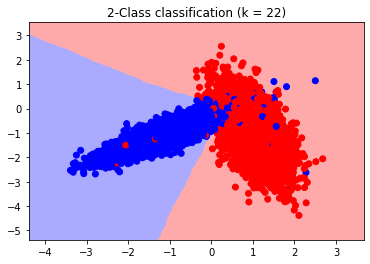

In [15]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = n_neigh_hp)
neigh.fit(x_train, y_train)
plot_decision_boundary(x_train[:, 0], x_train[:, 1], y_train, neigh)